<a href="https://colab.research.google.com/github/hemanth346/mde_bs/blob/master/notebooks/Create_compressed_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!ls '/content/drive/My Drive/DL/mask_depthmap_data/Compressed_Dataset'

bg  fg	fg_masks


In [0]:
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

In [0]:
root_dir = '/content/drive/My Drive/DL/mask_depthmap_data/Compressed_Dataset'
os.listdir(root_dir)

['bg', 'fg', 'fg_masks']

In [0]:
for root, folders, files in os.walk(root_dir):
  for folder in folders:
    print(folder, len(os.listdir(os.path.join(root, folder))))

bg 100
fg 100
fg_masks 100


In [0]:
# Path(root_dir).joinpath('bg')
bg_dir = Path(root_dir+'/bg')
fg_dir = Path(root_dir+'/fg')
fg_masks_dir = Path(root_dir+'/fg_masks')
fg_bg_dir = Path(root_dir+'/fg_bg')
mask_dir = Path(root_dir+'/fg_bg_masks')
depth_dir = Path(root_dir+'/depth_maps')

In [0]:
Path(fg_masks_dir).mkdir(exist_ok=True)
Path(fg_bg_dir).mkdir(exist_ok=True)
Path(mask_dir).mkdir(exist_ok=True)
Path(depth_dir).mkdir(exist_ok=True)
Path(root_dir+'/labels').mkdir(exist_ok=True)
os.listdir(root_dir)

['bg', 'fg', 'fg_masks', 'fg_bg', 'fg_bg_masks', 'depth_maps', 'labels']

In [0]:
fg_masks_dir, os.listdir(fg_masks_dir)[:5]

(PosixPath('/content/drive/My Drive/DL/mask_depthmap_data/Compressed_Dataset/fg_masks'),
 ['person1.png', 'person2.png', 'person3.png', 'person4.png', 'person5.png'])

In [0]:
# Create fg_masks if masks not present
if not os.listdir(fg_masks_dir):
    print('Generating fg masks...')
    for fname in os.listdir(fg_dir):
        img_path = os.path.join(fg_dir,fname)
        fg  =  cv2.imread(img_path, -1) # flag for cv2.IMREAD_UNCHANGED to read alpha channels
        # single channel mask
        _,  fg_mask  =  cv2.threshold(fg[:,  :,  3],  0,  255,  cv2.THRESH_BINARY)
        # keeping the fname same for easy of preprocessing
        mask_name = os.path.join(fg_masks_dir, fname)
        cv2.imwrite(mask_name, fg_mask)
os.listdir(fg_masks_dir)[:5]

['person1.png', 'person2.png', 'person3.png', 'person4.png', 'person5.png']

Get Depth model ready

In [0]:
! git clone https://github.com/hemanth346/DenseDepth.git -q 

In [0]:
cd /content/DenseDepth

/content/DenseDepth


In [0]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O nyu.h5

--2020-05-23 11:29:06--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.109.43
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.109.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘nyu.h5’

nyu.h5              100%[===================>] 164.89M  19.5MB/s    in 9.5s    

2020-05-23 11:29:16 (17.3 MB/s) - ‘nyu.h5’ saved [172897376/172897376]



In [0]:
%tensorflow_version 1.x
import os
import glob
from keras.models import load_model
from matplotlib import pyplot as plt

from layers import BilinearUpSampling2D
from utils import predict_single_file
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.





Helper functions to generate and save/compress the data

In [0]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime
import zipfile
from tqdm import tqdm
import math

def generate(root_dir, bg_fname, bg_size=224, number=20, 
            depth_maps=False, bbox_file=True, save=True, 
            compress=True, compression = zipfile.ZIP_STORED, show=False):
    """
    Given data root_dir with bg,fg anf fg_masks folder where foreground images have 
    alphachannel(flag -1 in cv2.imread) this generates 2*number of images per fg and bg 
    combination by placing foreground and its flip on top of bg randomly
    
    Place corresponding mask on a black canvas, to match the fg placement on bg
    If depth model prediction is available, will fecth depth maps as well
    """
    root_dir = root_dir
    bg_name = Path(bg_fname).stem

    bg_dir = root_dir+'/bg'
    fg_dir = root_dir+'/fg'
    fg_mask_dir = root_dir+'/fg_masks'
    fg_bg_dir = root_dir+'/fg_bg'
    mask_dir = root_dir+'/fg_bg_masks'
    depth_dir = root_dir+'/depth_maps'
    label_dir = root_dir+'/labels'

    bg = cv2.imread(os.path.join(bg_dir, bg_fname))
    bg = cv2.resize(bg, (224, 224), interpolation=cv2.INTER_CUBIC)

    if save:
        # current_dir
        cfg_bg_dir = Path(fg_bg_dir).joinpath(bg_name)
        cmask_dir = Path(mask_dir).joinpath(bg_name)
        cdepth_dir = Path(depth_dir).joinpath(bg_name)

        # create if not exist
        Path(cfg_bg_dir).mkdir(parents=True, exist_ok=True)
        Path(cmask_dir).mkdir(parents=True, exist_ok=True)
        Path(cdepth_dir).mkdir(parents=True, exist_ok=True)
    
    if compress:
        # Current bg zipfiles
        cfg_bg_zip_name = Path(fg_bg_dir).joinpath(bg_name + '.zip')
        cmask_zip_name = Path(mask_dir).joinpath(bg_name + '.zip')
        cdepth_zip_name = Path(depth_dir).joinpath(bg_name + '.zip')
        
        print('Using compression : ', str(compression))
        cfg_bg_zip = zipfile.ZipFile(cfg_bg_zip_name, mode='a', compression=compression)
        cmask_zip = zipfile.ZipFile(cmask_zip_name, mode='a', compression=compression)
        cdepth_zip = zipfile.ZipFile(cdepth_zip_name, mode='a', compression=compression)

    labels_file=None
    if bbox_file:
        labels_file = os.path.join(root_dir, 'labels', bg_name+'_labels.txt')
        file_object = open(labels_file, 'a')

    # iterate over all the fg images for each bg image
    for fgname in tqdm(os.listdir(fg_dir)):
        fg_img = os.path.join(fg_dir, fgname)
        fg_mask = os.path.join(fg_mask_dir, fgname)
        
        # set flag to -1 to read alpha channels as well
        fg = cv2.imread(fg_img, -1)
        mask = cv2.imread(fg_mask)

        if fg[:, :, 3] is None:
            print(f'No alpha channel detected in FG {fgname} image')
            return 1

        height_factor = fg.shape[0]/100
        width_factor = math.ceil(fg.shape[-1]/height_factor)
        
        fg = cv2.resize(fg, (width_factor*100, 100), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (width_factor*100, 100), interpolation=cv2.INTER_AREA)


#         fg = cv2.resize(fg, (70, 100), interpolation=cv2.INTER_AREA)
#         mask = cv2.resize(mask, (70, 100), interpolation=cv2.INTER_AREA)
        fg_flip = cv2.flip(fg, flipCode=1)
        mask_flip = cv2.flip(mask, flipCode=1)
                
        # To stop fg from overshooting bg canvas
        x_offset_limit = bg.shape[1] - fg.shape[1]
        y_offset_limit = bg.shape[0] - fg.shape[0]

        # width - X axis starting points from left
        x_offsets = random.sample(range(1, x_offset_limit), number)

        # height - Y axis starting points from top
        y_offsets = random.sample(range(1, y_offset_limit), number)


        for num, (x_offset, y_offset) in enumerate(zip(x_offsets, y_offsets)):
            # extracting only file name irrespective of extension, if given
            fname = Path(fgname).stem+'_'+str(num+1)+Path(fgname).suffix
            # BBOX coord - (x1, y1) and (x2, y2)
            y1, y2 = y_offset, y_offset + fg.shape[0]
            x1, x2 = x_offset, x_offset + fg.shape[1]

            alpha_fg = fg[:, :, 3] / 255.0
            alpha_fg_flip = fg_flip[:, :, 3] / 255.0

            alpha_bg = 1.0 - alpha_fg
            alpha_bg_flip = 1.0 - alpha_fg_flip

            # Not disturbing orignal images
            fg_bg = bg.copy()
            flip_fg_bg = bg.copy()

            black = bg * np.zeros(bg.shape, dtype=np.int8)
            flip_black = bg * np.zeros(bg.shape, dtype=np.int8)

            for c in range(0, 3):
                fg_bg[y1:y2, x1:x2, c] = (alpha_fg * fg[:, :, c] +
                                          alpha_bg * fg_bg[y1:y2, x1:x2, c])
                
                black[y1:y2, x1:x2, c] = (alpha_fg * mask[:, :, c] +
                                              alpha_bg * black[y1:y2, x1:x2, c])

                # flip images
                flip_fg_bg[y1:y2, x1:x2, c] = (alpha_fg_flip * fg_flip[:, :, c] +
                                          alpha_bg_flip * flip_fg_bg[y1:y2, x1:x2, c])

                flip_black[y1:y2, x1:x2, c] = (alpha_fg_flip * mask_flip[:, :, c] +
                                              alpha_bg_flip * flip_black[y1:y2, x1:x2, c])

            # convert mask to single channel grayscale
            fg_bg_mask = black[:,:,0]
            flip_fg_bg_mask = flip_black[:,:,0]

            if labels_file:
                # each line will have corresponding bbox
                coord = ', '.join(list(map(str, (x1, y1, x2, y2))))
                file_object.write(coord+' '+fname+'\n')
                file_object.write(coord+' '+'flip_'+fname+'\n')
        
            # inside the loop
            if depth_maps:
                depth_start = datetime.datetime.now()
                cv2.imwrite('temp_fg_bg.png', fg_bg)
                cv2.imwrite('temp_flip_fg_bg.png', flip_fg_bg)
                # takes in a file and return a single channel PIL image
                depth_img = predict_single_file('temp_fg_bg.png', model=model, size=(224, 224))
                flip_depth_img = predict_single_file('temp_flip_fg_bg.png', model=model, size=(224, 224))
                depth_time = datetime.datetime.now() - depth_start

            if save:
                # can reduce image quality for save if required
                # save fg_bg and flip_fg_bg
                cv2.imwrite(str(cfg_bg_dir)+fname, fg_bg)
                cv2.imwrite(str(cfg_bg_dir)+fname, flip_fg_bg)

                # save fg_bg_masks and flip_fg_bg_masks
                # set quality of JPEG to 50, if required. default 95, lowest 0.
                cv2.imwrite(str(cmask_dir)+fname, fg_bg_mask) # , [cv2.IMWRITE_JPEG_QUALITY, 50])
                cv2.imwrite(str(cmask_dir)+fname, flip_fg_bg_mask) # , [cv2.IMWRITE_JPEG_QUALITY, 50])

                if depth_maps:
                    # save depth and flip_depth
                    # returns a PIL image, converting to np array for cv write, 
                    # since its a single channel direct conversion is not problem
                    # for RGB may have to inverse the color channels
                    cv2.imwrite(str(cdepth_dir)+fname, np.array(depth_img))
                    cv2.imwrite(str(cdepth_dir)+fname, np.array(flip_depth_img))


            if compress:
                # save fg_bg and flip_fg_bg
                cv2.imwrite('fg_bg_temp.jpg', fg_bg)
                cv2.imwrite('flip_fg_bg_temp.jpg', flip_fg_bg)
                # add to zipfile
                cfg_bg_zip.write('fg_bg_temp.jpg', bg_name+'_'+fname)
                cfg_bg_zip.write('flip_fg_bg_temp.jpg', bg_name+'_flip_'+fname)

                # save fg_bg_masks and flip_fg_bg_masks
                cv2.imwrite('mask_temp.jpg', fg_bg_mask)
                cv2.imwrite('flip_mask_temp.jpg', flip_fg_bg_mask)
                # add to zipfile
                cmask_zip.write('mask_temp.jpg', bg_name+'_'+fname)
                cmask_zip.write('flip_mask_temp.jpg', bg_name+'_flip_'+fname)

                if depth_maps:
                    # save depth and flip_depth
                    # returns a PIL image, converting to np array for cv write, 
                    # since its a single channel direct conversion is not problem
                    # for RGB may have to inverse the color channels
                    cv2.imwrite('depth_temp.jpg', np.array(depth_img))
                    cv2.imwrite('flip_depth_temp.jpg', np.array(flip_depth_img))

                    # add to zipfile
                    cdepth_zip.write('depth_temp.jpg', bg_name+'_'+fname)
                    cdepth_zip.write('flip_depth_temp.jpg', bg_name+'_flip_'+fname)

    if labels_file:
        file_object.close()
    
    if compress:
        cfg_bg_zip.close()
        cmask_zip.close()
        cdepth_zip.close()

            
    if show:
        print(fg_bg.shape, fg_bg_mask.shape)
        fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
        axes = ax.flatten()
        axes[0].imshow(fg_bg)
        axes[1].imshow(flip_fg_bg)
        axes[2].imshow(fg_bg_mask)
        axes[3].imshow(flip_fg_bg_mask)
        if depth_maps:
            print(depth_img.size)
            print('Last depth prediction time : {0}'.format(depth_time))
            fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
            axes = ax.flatten()
            axes[0].imshow(depth_img)
            axes[1].imshow(flip_depth_img)
        plt.show()

In [0]:
# set compression algorithm, if zlip is available compress
# else just store inside a zip file without compression
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
    print('Using compression')
except (ImportError, AttributeError):
    compression = zipfile.ZIP_STORED        
    print('Using no compression')

def run_generator(start, end, compression=compression):
    print(sorted(os.listdir(bg_dir))[start:end])
    for idx, fname in enumerate(sorted(os.listdir(bg_dir))[start:end]):
        print(idx+1)
        bg_start = datetime.datetime.now()
        
        generate(root_dir=root_dir, bg_fname=fname, bg_size=224, number=20, 
                depth_maps=True, bbox_file=True, save=False, 
                compress=True, compression=compression, show=True)
        
        print('*'*27)
        print('Time for BG {0} : {1}'.format(
            fname,
            datetime.datetime.now() - bg_start
            ))

Using compression


In [0]:
for root, folders, files in os.walk(root_dir):
  for folder in folders:
    print(folder, len(os.listdir(os.path.join(root, folder))))

bg 100
fg 100
fg_masks 100
fg_bg 95
fg_bg_masks 95
depth_maps 95
labels 95


['office95.jpg', 'office96.jpg', 'office97.jpg', 'office98.jpg', 'office99.jpg']
1


  0%|          | 0/100 [00:00<?, ?it/s]

Using compression :  8


100%|██████████| 100/100 [05:41<00:00,  3.42s/it]


(224, 224, 3) (224, 224)
(224, 224)
Last depth prediction time : 0:00:00.155797


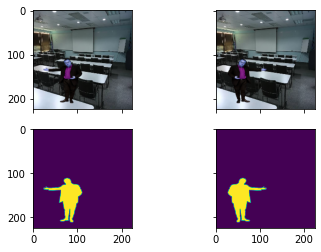

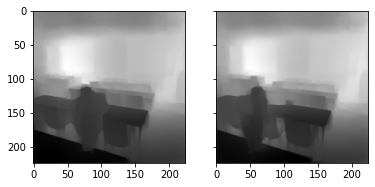

***************************
Time for BG office95.jpg : 0:05:43.106068
2


  0%|          | 0/100 [00:00<?, ?it/s]

Using compression :  8


100%|██████████| 100/100 [05:37<00:00,  3.37s/it]


(224, 224, 3) (224, 224)
(224, 224)
Last depth prediction time : 0:00:00.156808


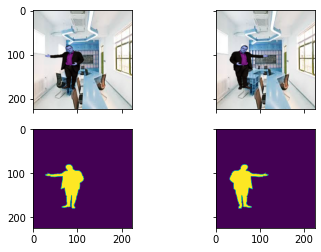

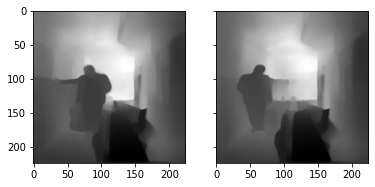

***************************
Time for BG office96.jpg : 0:05:38.440726
3


  0%|          | 0/100 [00:00<?, ?it/s]

Using compression :  8


100%|██████████| 100/100 [05:39<00:00,  3.39s/it]


(224, 224, 3) (224, 224)
(224, 224)
Last depth prediction time : 0:00:00.154658


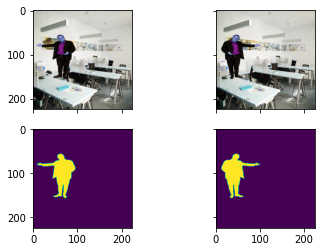

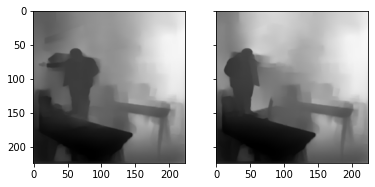

***************************
Time for BG office97.jpg : 0:05:40.279797
4


  0%|          | 0/100 [00:00<?, ?it/s]

Using compression :  8


100%|██████████| 100/100 [05:39<00:00,  3.40s/it]


(224, 224, 3) (224, 224)
(224, 224)
Last depth prediction time : 0:00:00.153158


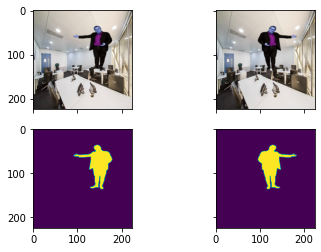

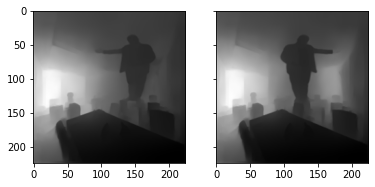

***************************
Time for BG office98.jpg : 0:05:40.941113
5


  0%|          | 0/100 [00:00<?, ?it/s]

Using compression :  8


100%|██████████| 100/100 [05:38<00:00,  3.39s/it]


(224, 224, 3) (224, 224)
(224, 224)
Last depth prediction time : 0:00:00.164527


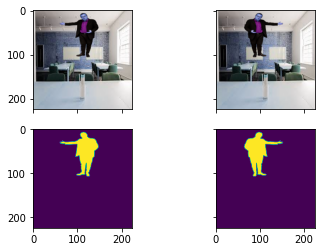

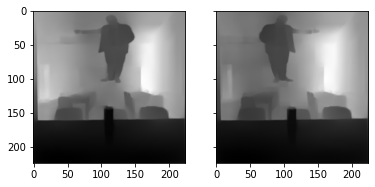

***************************
Time for BG office99.jpg : 0:05:39.675225


In [0]:
run_generator(95,100)

In [0]:
for root, folders, files in os.walk(root_dir):
  for folder in folders:
    print(folder, len(os.listdir(os.path.join(root, folder))))

bg 100
fg 100
fg_masks 100
fg_bg 100
fg_bg_masks 100
depth_maps 100
labels 100


In [0]:
! find '/content/drive/My Drive/DL/mask_depthmap_data/Compressed_Dataset' -type f -name office99.zip | xargs -d "\n" du -sh

92M	/content/drive/My Drive/DL/mask_depthmap_data/Compressed_Dataset/fg_bg/office99.zip
75M	/content/drive/My Drive/DL/mask_depthmap_data/Compressed_Dataset/fg_bg_masks/office99.zip
28M	/content/drive/My Drive/DL/mask_depthmap_data/Compressed_Dataset/depth_maps/office99.zip
